# Análise de Qualidade dos Dados

Este notebook verifica a qualidade do dataset de dados de vento, identificando dados ausentes, gaps temporais e outros problemas.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuração dos gráficos
plt.style.use('default')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

In [23]:
# Carregar o dataset
df = pd.read_csv('../wind_data.csv', parse_dates=['timestamp'])
print(f"Dataset carregado: {df.shape[0]} linhas, {df.shape[1]} colunas")
print(f"Período: {df['timestamp'].min()} a {df['timestamp'].max()}")

Dataset carregado: 47900 linhas, 34 colunas
Período: 2021-11-10 17:20:00 a 2022-10-09 08:30:00


In [24]:
# Informações básicas do dataset
print("Primeiras 5 linhas:")
print(df.head())
print("\nTipos de dados:")
print(df.dtypes)

Primeiras 5 linhas:
            timestamp  ws40  ws50  ws60  ws70  ws80  ws90  ws100  ws110  \
0 2021-11-10 17:20:00  5.03  5.53  5.54  5.66  5.74  5.82   5.83   5.79   
1 2021-11-10 17:30:00  4.94  5.30  5.29  5.72  5.87  5.98   5.99   6.06   
2 2021-11-10 17:40:00  4.44  5.96  5.66  6.44  6.55  6.61   6.67   6.67   
3 2021-11-10 17:50:00  4.28  4.91  5.04  5.80  5.95  6.03   6.15   6.17   
4 2021-11-10 18:00:00  4.53  5.02  4.66  5.52  5.62  5.70   5.90   5.93   

   ws120  ...  dir50  dir60  dir70  dir80  dir90  dir100  dir110  dir120  \
0   5.71  ...   30.5   29.2   31.4   31.3   32.3    33.3    33.6    32.8   
1   6.18  ...   37.7   35.0   34.7   34.8   35.6    36.4    37.6    38.2   
2   6.63  ...   42.7   41.3   42.0   43.1   43.0    43.3    42.9    43.2   
3   6.24  ...   44.3   45.7   43.7   45.0   45.7    46.8    46.2    46.3   
4   6.15  ...   49.5   44.6   43.6   45.1   44.4    42.5    40.2    39.0   

   dir130  dir140  
0    31.4    30.8  
1    38.4    38.8  
2    42.6   

In [25]:
# Análise de dados ausentes
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100

# Criar dataframe com estatísticas de dados ausentes
missing_stats = pd.DataFrame({
    'Coluna': missing_count.index,
    'Valores_Ausentes': missing_count.values,
    'Percentual': missing_percent.values
})

# Filtrar apenas colunas com dados ausentes
missing_stats = missing_stats[missing_stats['Valores_Ausentes'] > 0]
missing_stats = missing_stats.sort_values('Percentual', ascending=False)

print(f"Total de colunas com dados ausentes: {len(missing_stats)}")
print(missing_stats.head(10))

Total de colunas com dados ausentes: 33
    Coluna  Valores_Ausentes  Percentual
22    v140              8306   17.340292
21    v130              7966   16.630480
11   ws140              7844   16.375783
33  dir140              7844   16.375783
20    v120              7665   16.002088
32  dir130              7511   15.680585
10   ws130              7511   15.680585
19    v110              7406   15.461378
9    ws120              7261   15.158664
31  dir120              7261   15.158664


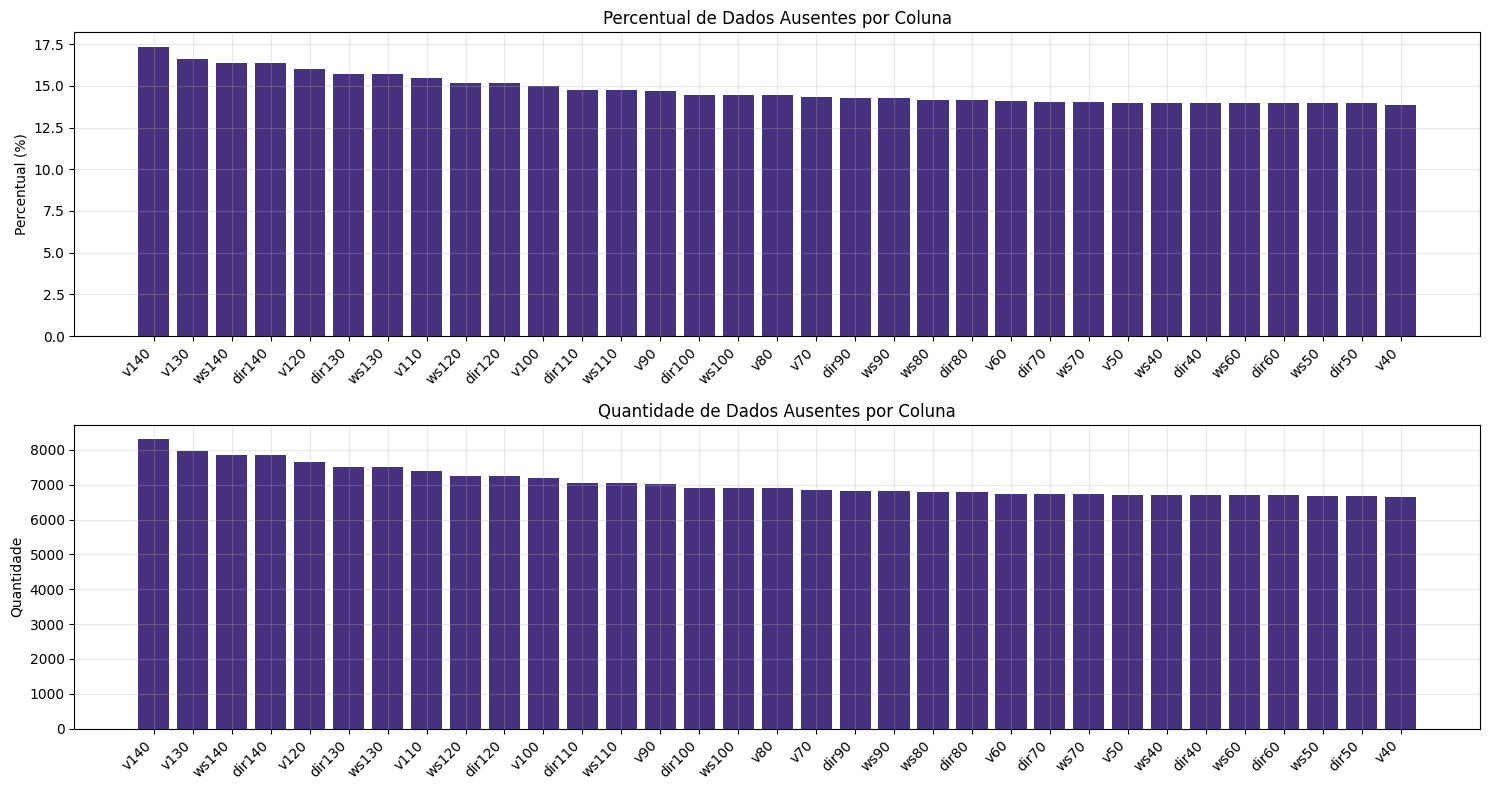

In [26]:
# Gráfico de barras dos dados ausentes por coluna
if len(missing_stats) > 0:
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.bar(range(len(missing_stats)), missing_stats['Percentual'])
    plt.title('Percentual de Dados Ausentes por Coluna')
    plt.ylabel('Percentual (%)')
    plt.xticks(range(len(missing_stats)), missing_stats['Coluna'], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.bar(range(len(missing_stats)), missing_stats['Valores_Ausentes'])
    plt.title('Quantidade de Dados Ausentes por Coluna')
    plt.ylabel('Quantidade')
    plt.xticks(range(len(missing_stats)), missing_stats['Coluna'], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum dado ausente encontrado!")

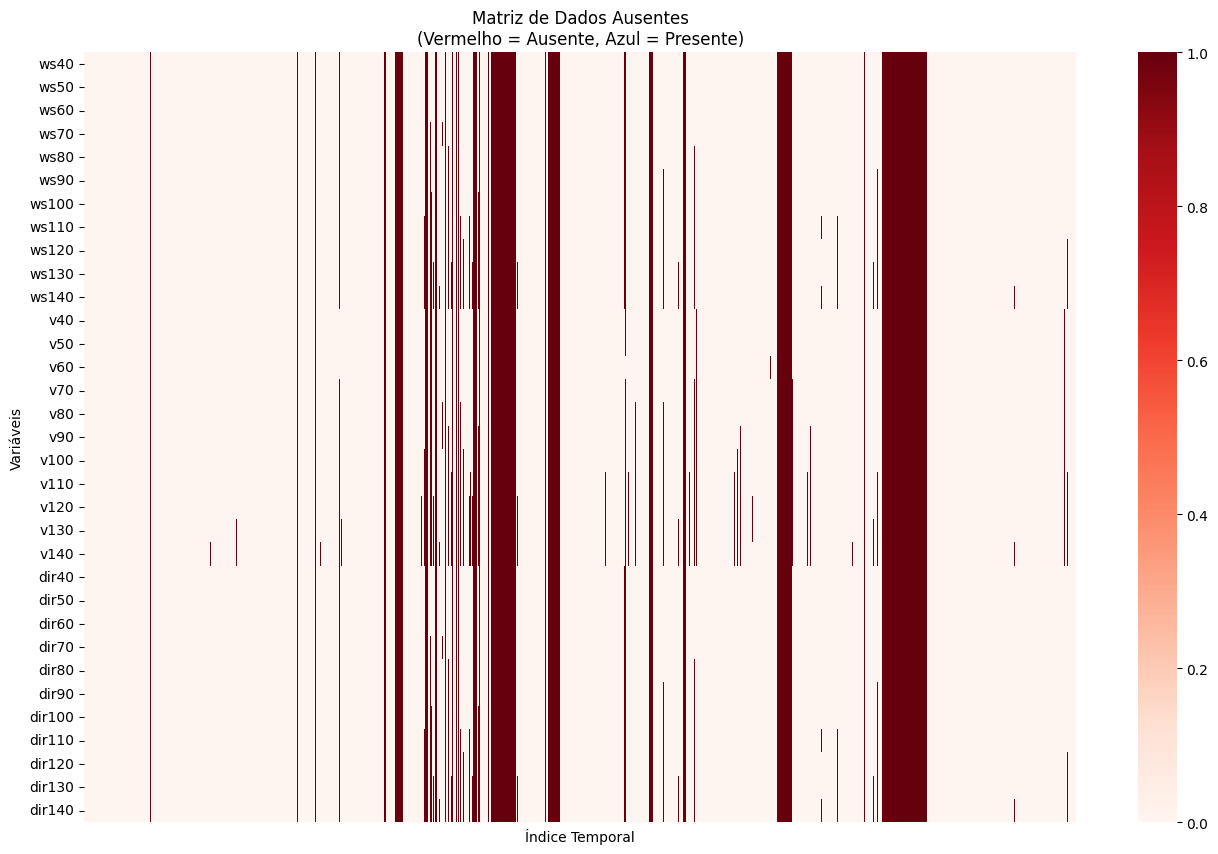

Total de valores ausentes no dataset: 233444


In [27]:
# Matriz de dados ausentes
# Selecionar apenas colunas numéricas (excluindo timestamp)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Criar matriz binária (1 = dado ausente, 0 = dado presente)
missing_matrix = df[numeric_cols].isnull().astype(int)

# Plotar heatmap da matriz de dados ausentes
plt.figure(figsize=(16, 10))
sns.heatmap(missing_matrix.T, 
            cbar=True, 
            cmap='Reds',
            xticklabels=False,
            yticklabels=True)
plt.title('Matriz de Dados Ausentes\n(Vermelho = Ausente, Azul = Presente)')
plt.xlabel('Índice Temporal')
plt.ylabel('Variáveis')
plt.show()

print(f"Total de valores ausentes no dataset: {missing_matrix.sum().sum()}")

In [28]:
# Análise de gaps temporais
df_sorted = df.sort_values('timestamp')
time_diffs = df_sorted['timestamp'].diff()

# Intervalo esperado (10 minutos baseado na descrição do projeto)
expected_interval = timedelta(minutes=10)

# Identificar gaps maiores que o esperado
gaps = time_diffs[time_diffs > expected_interval]

print(f"Intervalo esperado entre medições: {expected_interval}")
print(f"Número de gaps temporais encontrados: {len(gaps)}")

if len(gaps) > 0:
    print("\nMaiores gaps temporais:")
    gaps_sorted = gaps.sort_values(ascending=False)
    for i, (idx, gap) in enumerate(gaps_sorted.head(10).items()):
        timestamp = df_sorted.loc[idx, 'timestamp']
        print(f"{i+1}. {gap} em {timestamp}")

Intervalo esperado entre medições: 0:10:00
Número de gaps temporais encontrados: 0


In [29]:
# Visualização dos gaps temporais
if len(gaps) > 0:
    plt.figure(figsize=(15, 6))
    
    # Converter gaps para horas para melhor visualização
    gaps_hours = gaps.dt.total_seconds() / 3600
    
    plt.subplot(1, 2, 1)
    plt.hist(gaps_hours, bins=20, alpha=0.7, edgecolor='black')
    plt.title('Distribuição dos Gaps Temporais')
    plt.xlabel('Duração do Gap (horas)')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    gap_positions = df_sorted.loc[gaps.index, 'timestamp']
    plt.scatter(gap_positions, gaps_hours, alpha=0.6)
    plt.title('Gaps Temporais ao Longo do Tempo')
    plt.xlabel('Data')
    plt.ylabel('Duração do Gap (horas)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [30]:
# Análise de completude por altura SODAR
# Agrupar colunas por altura
heights = []
for col in numeric_cols:
    if 'SODAR' in col:
        height = col.split('-')[-1]
        if height not in heights:
            heights.append(height)

heights.sort(key=int)

# Calcular completude por altura
completeness_by_height = {}
for height in heights:
    height_cols = [col for col in numeric_cols if f'SODAR-{height}' in col]
    if height_cols:
        height_data = df[height_cols]
        total_values = height_data.size
        missing_values = height_data.isnull().sum().sum()
        completeness = ((total_values - missing_values) / total_values) * 100
        completeness_by_height[height] = completeness

# Plotar completude por altura
if completeness_by_height:
    plt.figure(figsize=(12, 6))
    heights_int = [int(h) for h in completeness_by_height.keys()]
    completeness_values = list(completeness_by_height.values())
    
    plt.plot(heights_int, completeness_values, 'o-', linewidth=2, markersize=8)
    plt.title('Completude dos Dados por Altura SODAR')
    plt.xlabel('Altura (m)')
    plt.ylabel('Completude (%)')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 105)
    
    # Adicionar valores nos pontos
    for height, completeness in zip(heights_int, completeness_values):
        plt.annotate(f'{completeness:.1f}%', 
                    (height, completeness), 
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')
    
    plt.show()
    
    print("Completude por altura:")
    for height in sorted(heights, key=int):
        print(f"  {height}m: {completeness_by_height[height]:.2f}%")

In [31]:
# Resumo da qualidade dos dados
total_values = df.select_dtypes(include=[np.number]).size
total_missing = df.select_dtypes(include=[np.number]).isnull().sum().sum()
overall_completeness = ((total_values - total_missing) / total_values) * 100

period_days = (df['timestamp'].max() - df['timestamp'].min()).days
expected_records = period_days * 24 * 6  # 6 registros por hora (intervalos de 10 min)
actual_records = len(df)
temporal_completeness = (actual_records / expected_records) * 100

print("=== RESUMO DA QUALIDADE DOS DADOS ===")
print(f"Período analisado: {period_days} dias")
print(f"Registros esperados: {expected_records:,}")
print(f"Registros encontrados: {actual_records:,}")
print(f"Completude temporal: {temporal_completeness:.2f}%")
print(f"")
print(f"Total de valores: {total_values:,}")
print(f"Valores ausentes: {total_missing:,}")
print(f"Completude geral: {overall_completeness:.2f}%")
print(f"")
print(f"Gaps temporais detectados: {len(gaps)}")
if len(gaps) > 0:
    print(f"Maior gap: {gaps.max()}")
    print(f"Gap médio: {gaps.mean()}")

=== RESUMO DA QUALIDADE DOS DADOS ===
Período analisado: 332 dias
Registros esperados: 47,808
Registros encontrados: 47,900
Completude temporal: 100.19%

Total de valores: 1,580,700
Valores ausentes: 233,444
Completude geral: 85.23%

Gaps temporais detectados: 0
